# Is making song an art or science?

In [91]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

In [3]:
df = pd.read_csv('dataset-of-00s.csv')

In [4]:
df.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,0.368000,0.00000,0.159,0.532,133.061,196707,4,30.88059,13,1
1,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,0.018500,0.00000,0.148,0.688,92.988,242587,4,41.51106,10,1
2,Clouds Of Dementia,Candlemass,spotify:track:6cHZf7RbxXCKwEkgAZT4mY,0.162,0.836,9,-3.009,1,0.0473,0.000111,0.00457,0.174,0.300,86.964,338893,4,65.32887,13,0
3,"Heavy Metal, Raise Hell!",Zwartketterij,spotify:track:2IjBPp2vMeX7LggzRN3iSX,0.188,0.994,4,-3.745,1,0.1660,0.000007,0.07840,0.192,0.333,148.440,255667,4,58.59528,9,0
4,I Got A Feelin',Billy Currington,spotify:track:1tF370eYXUcWwkIvaq3IGz,0.630,0.764,2,-4.353,1,0.0275,0.363000,0.00000,0.125,0.631,112.098,193760,4,22.62384,10,1


Number of Rows

In [5]:
len(df)

5872

Base Rate

In [6]:
df['target'].mean()

0.5

In [7]:
#drop useless column
df = df.drop('uri', axis=1)

In [8]:
X = df.iloc[:,:-1]
y = df.iloc[:, -1]

## EDA

### Is there relation between the notes you use the most in your song and probability of song's success?

<AxesSubplot:xlabel='key', ylabel='count'>

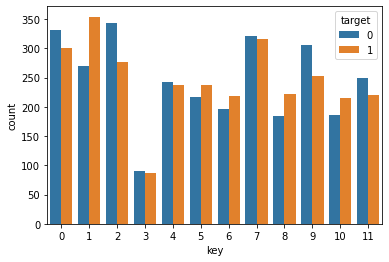

In [9]:
sns.countplot(data = df, x = "key", hue = "target")

No

### Is there a "holy grail" song duration that increases chances of success?

(0.0, 14.0)

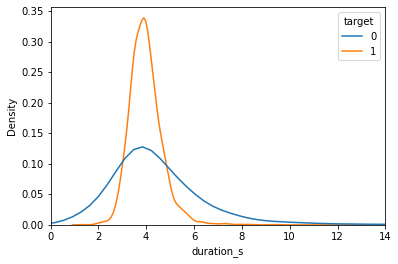

In [10]:
df['duration_s'] = df['duration_ms']/60000
sns.kdeplot(data = df, x = "duration_s", hue = "target")
plt.xlim(0,14)

Yes.
Anything out of the range of (2, 6) min has a low chance of success

### Do dance numbers have higher chances of being hit?

<AxesSubplot:xlabel='target', ylabel='danceability'>

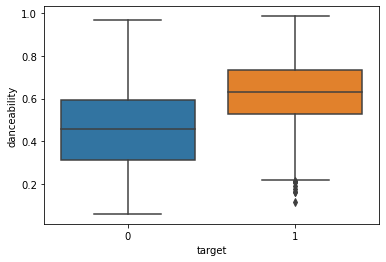

In [11]:
sns.boxplot(data = df, y = "danceability", x = "target")

<AxesSubplot:xlabel='danceability', ylabel='Density'>

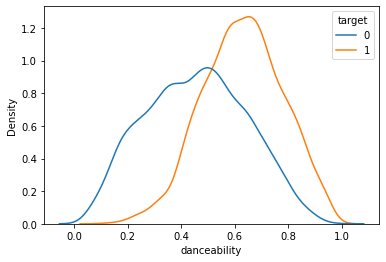

In [12]:
sns.kdeplot(data = df, x = "danceability", hue = "target")

Definitely, there some relation between dancability and song's chances of being a hit

### Do loud and high energy songs have a higher chance of being a hit?

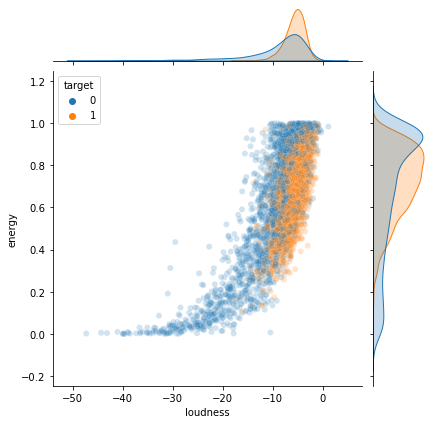

In [13]:
sns.jointplot(data = df, x = 'loudness', y = 'energy', hue='target', alpha= 0.2)

Some combinations definitely have higher chances of being a hit than others

### When should you put in your chorus to garauntee success?

<AxesSubplot:xlabel='chorus_perc', ylabel='Density'>

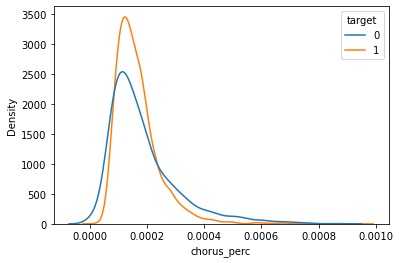

In [14]:
df['chorus_perc'] = df['chorus_hit'] / df['duration_ms'] 
sns.kdeplot(data = df, x = 'chorus_perc', hue = 'target')

No clear differentiation. Singer seem to be adding their chorus at the same time

### Are hit singers born or made?

In [15]:
artist_hit_stat = df.groupby('artist')['target'].agg(['mean', 'count'])
artist_hit_stat = artist_hit_stat[artist_hit_stat['count'] > 2]

<AxesSubplot:xlabel='mean', ylabel='Count'>

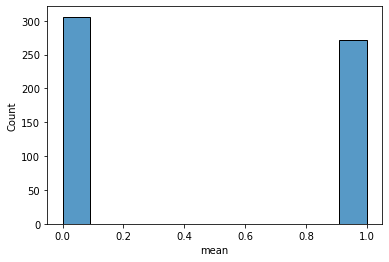

In [16]:
sns.histplot(artist_hit_stat, x = 'mean')

So acc. to this data, if your first song was not a hit then there are zero chances of song being a hit.

## Modelling

In [173]:
# startifying based on target so that class represntation is same in train and test 
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                    train_size=0.9,
                                                    stratify = y)

In [174]:
# startifying based on target so that class represntation is same in train and test 
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, 
                                                    train_size=0.8,
                                                    stratify = train_y)

In [175]:
scaler = StandardScaler()

train_X = scaler.fit_transform(train_X.iloc[:, 2:])
val_X = scaler.fit_transform(val_X.iloc[:, 2:])

test_X = scaler.fit_transform(test_X.iloc[:, 2:])

We will skip character columns for first model

In [176]:
lr = LogisticRegression(C = 1)

In [177]:
lr.fit(train_X, train_y)

LogisticRegression(C=1)

<AxesSubplot:>

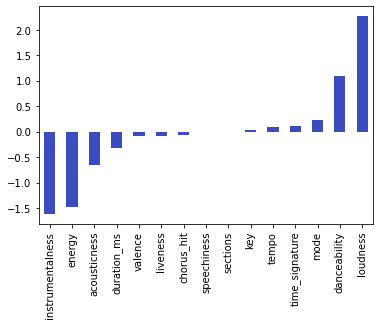

In [178]:
pd.Series(index = X.columns.values[2:], 
          data = lr.coef_.tolist()[0]).\
                    sort_values().\
                    plot(kind = 'bar', cmap = "coolwarm")

In [179]:
lr.score(train_X, train_y)

0.8237520700260231

In [180]:
lr.score(val_X, val_y)

0.8164616840113529

In [181]:
predictions = lr.predict(val_X)

confusion_matrix(val_y, predictions)

array([[396, 132],
       [ 62, 467]], dtype=int64)

In [182]:
rf = RandomForestClassifier(ccp_alpha = .001)

In [183]:
rf.fit(train_X, train_y)

RandomForestClassifier(ccp_alpha=0.001)

In [184]:
rf.feature_importances_

array([0.14075571, 0.06644377, 0.00578543, 0.11022103, 0.00466133,
       0.03582233, 0.0942743 , 0.30674758, 0.01550941, 0.05469288,
       0.01757116, 0.10788897, 0.00283456, 0.01353077, 0.02326076])

<AxesSubplot:>

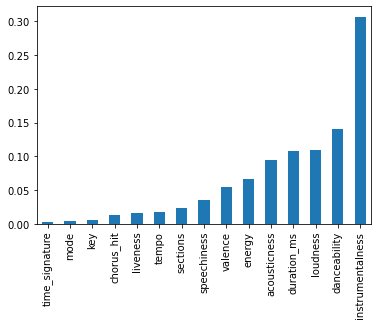

In [185]:
pd.Series(index = X.columns.values[2:], 
          data = rf.feature_importances_.tolist()).\
                    sort_values().\
                    plot(kind = 'bar')

In [186]:
rf.score(train_X, train_y)

0.8970901348474095

In [187]:
rf.score(val_X, val_y)

0.8230842005676443

In [188]:
predictions = rf.predict(val_X)

confusion_matrix(val_y, predictions)

array([[463,  65],
       [122, 407]], dtype=int64)

In [189]:
xgb = XGBClassifier(eta = 0.4)

In [190]:
xgb.fit(train_X, train_y)

C:\Users\singl\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.4, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.400000006, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [191]:
xgb.score(train_X, train_y)

0.9990537023894015

In [192]:
xgb.score(val_X, val_y)

0.8429517502365185

In [193]:
predictions = xgb.predict(val_X)

confusion_matrix(val_y, predictions)

array([[454,  74],
       [ 92, 437]], dtype=int64)

In [194]:
lr.score(test_X, test_y)

0.8316326530612245

In [195]:
rf.score(test_X, test_y)

0.7465986394557823

In [196]:
xgb.score(test_X, test_y)

0.8299319727891157